In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM, TimeDistributed
from keras.layers import Concatenate, Flatten
from keras.layers import GRU, Conv2D, MaxPooling2D
from keras.layers import Input, Reshape, Dot, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.utils.vis_utils import plot_model
import keras
import keras.backend as K
from data_handle import *
from gensim_wrapper import *
from utils import *
import gensim
import random
import numpy as np
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
seed_val = 1000
random.seed(seed_val)
np.random.seed(seed_val)
tf.set_random_seed(seed_val)

c:\users\amany\appdata\local\conda\conda\envs\gputf3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
c:\users\amany\appdata\local\conda\conda\envs\gputf3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
def conv_model_multi(n_chars, n_consonant, n_vowels, n_units):
    root_word_input = Input(shape=(n_chars, (n_consonant + n_vowels), 1), name="root_word_input")
    
    x = Conv2D(10, (5, 5), padding='same', activation='relu')(root_word_input)
    x = MaxPooling2D(3, 3)(x)

    x = Flatten()(x)

    state_h = Dense(n_units, activation='linear')(x)
    
    consonant_decoder_inputs = Input(shape=(None, n_consonant), name="target_consonant")
    consonant_decoder_gru = GRU(n_units, return_sequences=True, return_state=True,  name="consonant_decoder_gru")
    consonant_decoder_outputs, _= consonant_decoder_gru(consonant_decoder_inputs, initial_state=state_h)
    
    vowel_decoder_inputs = Input(shape=(None, n_vowels), name="vowel_input")
    vowel_decoder_gru = GRU(n_units, return_sequences=True, return_state=True, name="vowl_decoder_gru")
    vowel_decoder_outputs, _= vowel_decoder_gru(vowel_decoder_inputs, initial_state=state_h)

    consonant_decoder_dense = Dense(n_consonant, activation='softmax', name="consonant_output")
    consonant_decoder_outputs = consonant_decoder_dense(consonant_decoder_outputs)
    
    vowel_decoder_dense = Dense(n_vowels, activation='softmax', name="vowel_output")
    vowel_decoder_outputs = vowel_decoder_dense(vowel_decoder_outputs)
    
    main_model = Model([root_word_input, consonant_decoder_inputs, vowel_decoder_inputs], [consonant_decoder_outputs, vowel_decoder_outputs])
    
    encoder_model = Model(root_word_input, state_h)
    
    decoder_state_input_h = Input(shape=(n_units,))
    
    consonant_decoder_outputs, state_h= consonant_decoder_gru(consonant_decoder_inputs, initial_state=decoder_state_input_h)
    consonant_decoder_outputs = consonant_decoder_dense(consonant_decoder_outputs)
    
    vowel_decoder_outputs, state_h= vowel_decoder_gru(vowel_decoder_inputs, initial_state=decoder_state_input_h)
    vowel_decoder_outputs = vowel_decoder_dense(vowel_decoder_outputs)
    
    decoder_model = Model([consonant_decoder_inputs, vowel_decoder_inputs, decoder_state_input_h], [consonant_decoder_outputs, vowel_decoder_outputs, state_h])

    return main_model, encoder_model, decoder_model

def one_hot_sep(con, con_max, vow, vow_max):
    con_vec = np.zeros((con_max, ))
    con_vec[con] = 1
    vow_vec = np.zeros((vow_max, ))
    vow_vec[vow] = 1
    return con_vec, vow_vec
    
def decode_multi_sequence(model, char2tup, tup2char, state, n_consonant, n_vowels):
    con, vow = char2tup['&']
    con_vec, vow_vec = one_hot_sep(con, n_consonant, vow, n_vowels) 
    con_vec = con_vec.reshape((1, 1, -1))
    vow_vec = vow_vec.reshape((1, 1, -1))
#     target_seq = np.concatenate([con_vec, vow_vec])
    decoded_chars = []
    for i in range(13):
        con_vec, vow_vec, state = model.predict([con_vec, vow_vec, state])
#         target_seq = np.concatenate([con_vec, vow_vec])
        new_con_vec = np.zeros_like(con_vec)
        new_con_vec[0, 0, np.argmax(con_vec[0, 0, :])] = 1
        new_vow_vec = np.zeros_like(vow_vec)
        new_vow_vec[0, 0, np.argmax(vow_vec[0, 0, :])] = 1
        con_vec, vow_vec = new_con_vec, new_vow_vec
        name = "{0}-{1}".format(np.argmax(con_vec[0, 0, :]), np.argmax(vow_vec[0, 0, :]))
        try:
            char = tup2char[name]
        except:
            char = ' '
        decoded_chars += [char]
    
    return decoded_chars

def pred_embeddings_multi(vocab, encoder, char2tup):
    embeddings = np.ndarray((len(vocab), embed_size))
    i = 0
    buffer = []
    buffer_size = 10000
    for wi, word in enumerate(vocab):
        word = int2word[word2int[word]]
        convec, vowvec = word2vec_seperated(char2tup, word, n_chars, n_consonant, n_vowel)
        mat = np.concatenate([convec, vowvec], axis=1)
        buffer.append(mat)
        if len(buffer) == buffer_size or len(vocab) - wi < buffer_size:
            buffer_np = np.stack(buffer).reshape((-1, n_chars, (n_consonant + n_vowel), 1))
            result = encoder.predict(buffer_np)
            embeddings[i:i+len(buffer)] = result
            i += len(buffer)
            buffer = []
            if i % (4 *buffer_size) == 0:
                print("Predicting: {0:.2f}%".format((i * 100.0 / len(vocab))))
    print("finished")
    return embeddings

In [11]:
words = read_file()
vocab, word2int, int2word = build_vocab(words)
int_words = words_to_ints(word2int, words)
word2freq = get_frequency(words, word2int, int2word)
char2int, int2char, char2tup, tup2char, n_consonant, n_vowel = build_charset()
ns_unigrams = ns_sample(word2freq, word2int, int2word, .75)
n_chars = 11 + 2 
n_features = len(char2int)
batch_size = 120
embed_size = 128
skip_window = 5
n_batches = len(vocab) // batch_size

In [12]:
multi_gen = generate_word_images_multi(words, char2tup, batch_size, n_consonant, n_vowel)

In [19]:
keras.backend.clear_session()
multi_train, multi_enc, multi_dec = conv_model_multi(n_chars, n_consonant, n_vowel, embed_size)
adam = keras.optimizers.Nadam(0.001)
multi_train.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])
plot_model(multi_train)
# multi_train.summary()

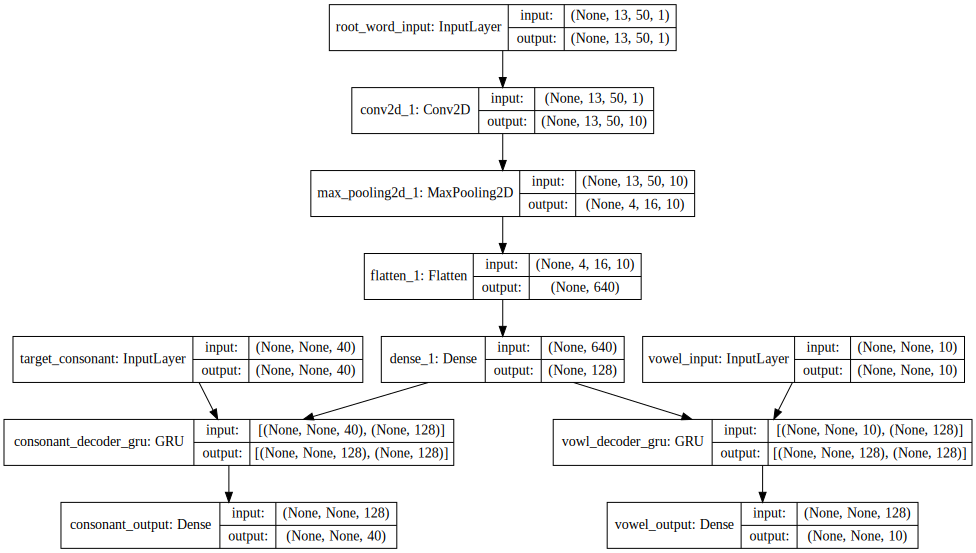

In [18]:
SVG(model_to_dot(multi_train, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
history = multi_train.fit_generator(multi_gen, steps_per_epoch=n_batches, epochs = 3)

Epoch 1/3
2481/2481 [==============================] - 104s 42ms/step - loss: 0.2392 - consonant_output_loss: 0.1484 - vowel_output_loss: 0.0908 - consonant_output_acc: 0.9693 - vowel_output_acc: 0.9746
Epoch 2/3
2481/2481 [==============================] - 100s 40ms/step - loss: 0.0353 - consonant_output_loss: 0.0174 - vowel_output_loss: 0.0179 - consonant_output_acc: 0.9981 - vowel_output_acc: 0.9979
Epoch 3/3
2481/2481 [==============================] - 229s 92ms/step - loss: 0.0201 - consonant_output_loss: 0.0098 - vowel_output_loss: 0.0104 - consonant_output_acc: 0.9989 - vowel_output_acc: 0.9990


In [16]:
embeddings = pred_embeddings_multi(vocab, multi_enc, char2tup)

Predicting: 13.43%
Predicting: 26.86%
Predicting: 40.29%
Predicting: 53.72%
Predicting: 67.15%
Predicting: 80.58%
Predicting: 94.01%
finished


In [17]:
print(evaluate(word2int, normalize(embeddings)))

c:\users\amany\appdata\local\conda\conda\envs\gputf3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'anomaly': 64.22018348623853, 'semantic': 0.5405405405405406, 'syntactic': 20.454545454545453}
